### Quadrinôme :
- ABDESSAMED BOULARIACHE
- KEMOUM Meroua
- MAHIDDINE Mohamed Amine
- TAZIR REDA

# TP 6 Réseaux de neurones - Multi classification et Propagation en arrière
Dans ce TP, nous aimerions entrainer un réseau de neurones pour la tâche de classification en utilisant l'algorithme d propagation en arrière (backpropagation).

L'ensemble de données que nous allons utiliser est le même que celui utilisé durant le TP1, i.e. les images de chiffres manuscrits.


# Importation des librairies necessaires au travail

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import cv2 
from sklearn.metrics import log_loss
from sklearn.neural_network import MLPClassifier

# Lecture des fichiers de données
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [2]:
# données
data = np.genfromtxt('data.csv', delimiter=',', dtype=float)
data.shape

(5000, 401)

Dans ces données (data), les 400 premières colonnes representent les pixels de l'image (20x20), la dernière colonne represente la classe de l'image (chiffres de 0 à 9). (http://yann.lecun.com/exdb/mnist/)

Chaque ligne represente un exemple de notre ensemble de données. 

Mettons ces données dans leus vecteurs correspondants.

In [3]:
# rajoutons l'ordonnée à l'origine theta 0
intercept=np.ones((data.shape[0],1))
X=np.column_stack((intercept,data[:,:-1]))
y=data[:,-1]
# forcer y à avoir une seule colonne
y = y.reshape( y.shape[0], 1)

In [4]:
print('X', X.shape ,' y ', y.shape)

X (5000, 401)  y  (5000, 1)


Visualisation aléatoire de quelques données

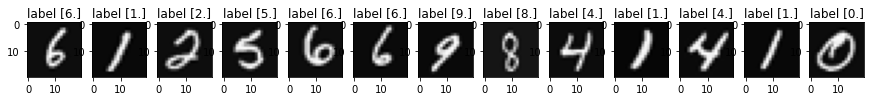

In [5]:
plt.figure(figsize=(15,8))
for i in range(13):
    c = random.randint(X.shape[0])
    a = X[c,1:].reshape((20, 20))
    a=np.transpose(a)
    plt.subplot(1,13,i+1)
    plt.title('label '+ str(y[c]))
    plt.imshow(a,cmap='gray')

Transformer y de tel sorte à avoir un vecteur pour chaque exemple

Equivalent de tocategorical

In [6]:
YY=np.zeros((y.shape[0], int(np.max(y))+1))
YY.shape

(5000, 10)

In [7]:
for i in range (YY.shape[0]):
    YY[i,int(y[i])]=1

# Réseaux de neurones
Pour cette partie, nous choisissons une réseau simple:

- une couche d'entrée avec 400 noeuds (20 x 20 pixels) + le biais
- une couche cachée avec 25 noeuds
- une couche de sortie avec 10 noeuds (nombre de classes)

In [8]:
# poids de la couche 1
W1 = np.genfromtxt('W1.csv', delimiter=',', dtype=float)
W1.shape


(25, 401)

In [9]:
# poids de la couche 2
W2 = np.genfromtxt('W2.csv', delimiter=',', dtype=float)
W2.shape

(10, 26)

In [10]:
input_layer_size  = 400;  
hidden_layer_size = 25;   
num_labels = 10;

# Calcul du coût

# TODO  1 calcul du coût
**Tâche 1**: Modifier la fonction computeCost afin d'obtenir un coût avec régularisation

Rappelons que le coût avec régularisation est calculé comme suit:

$ J(\theta)= \frac{1}{m} \sum_{i=1}^m\sum_{k=1}^K \left[ -y_k^{(i)} \log (h_\theta(x^{(i)}) )_k - (1-y_k^{(i)}) \log (1-h_\theta(x^{(i)}) )_k \right] + \frac{\lambda}{2m} \left[ \sum_{j=1}^{25}\sum_{k=1}^{400} \left( \theta_{j,k}^{(1)} \right)^2 +   \sum_{j=1}^{10}\sum_{k=1}^{25} \left( \theta_{j,k}^{(2)} \right)^2 \right] $

In [11]:
def Sigmoid(z):
    # pour une valeur donnée, cette fonction calculera sa sigmoid
    return 1/(1+np.exp(-z));

In [12]:
def computeCost(X, YY, theta1, theta2,hidden_layer_size, lambda_=0):
    a1=X; 

    z2= np.zeros((X.shape[0],hidden_layer_size))
    a2= np.zeros((X.shape[0],hidden_layer_size)) 

    intercept=np.ones((X.shape[0],1))
    z2=np.column_stack((intercept,np.matmul(a1,np.transpose(theta1))))
    a2=Sigmoid(z2)
    a2[:,0]=1

    z3= np.zeros((YY.shape[0],YY.shape[1]))    
    a3= np.zeros((YY.shape[0],YY.shape[1]))  

    z3=np.matmul(a2,np.transpose(theta2))
    a3=Sigmoid(z3)

    J=np.zeros((YY.shape[0],1))
    J= (1/y.shape[0])*(np.sum(np.sum((-YY*np.log(a3))-((1-YY)*np.log(1-a3)))));
    
    # ajouter la régularisation
    m = X.shape[0]
    J = J + (lambda_ / (2*m)) * (np.power(theta1[:, 1:], 2).sum() + np.power(theta2[:, 1:], 2).sum())

    return J

# TODO  2 calcul du gradient
**Tâche 2**: Implémenter la fonction NNCostFunction afin de retourner:

- Le coût avec régularisation
- Le gardient du coût par rapport à chaqu'un des paramètres du réseau

Rappelons le gradient de la sigmoid:

$ sigmoid(z) =\sigma(z)= \frac{1}{1-e^{-z}}$

$ \sigma(z)^\prime = \sigma(z)(1-\sigma(z)) =a(1-a)$ tel que $a$ est l'activation d'une couche donnée

L'algorithme à implementer est comme suit:

Pour chaque exemple de l'ensemble d'apprentissage faire

Pour chaque noeud de la couche de sortie, calculer la dérivée (gradient):

$\delta_k^{(3)} = \left( a_k^{(3)}- y_k \right)  $

Pour chaque noeud de la couche caché calculer la dérivée (gradient):

$\delta^{(2)} =  \left(\Theta^{(2)}\right)^T \delta^{(3)} \quad .* \quad \sigma^\prime\left(z^{(2)} \right) $

Notons que l'opérateur $.*$ represente la multiplication élement par élement et non pas la multiplication matricielle

Le gradient de chaque noeud et de chaque couche sera finalement:

$\Delta^{(l)} =  \Delta^{(l)} + \delta^{(l)} * \left( a^{(l)} \right)^T $

Fin pour

Fin pour

Diviser le gradient cumulé par le nombre d'exemples:

$ \frac{\partial J(\Theta)} { \partial \Theta_{i,j)}^{(l)}} = \frac{1}{m} \Delta_{i,j)}^{(l)}$


In [13]:
def NNCostFunction(X, YY, theta1, theta2,hidden_layer_sizen):
    #initialisation
    theta1_grad = np.zeros((theta1.shape[0],theta1.shape[1]))
    theta2_grad = np.zeros((theta2.shape[0],theta2.shape[1]))
    
    #faire la propagation en avant
    a1=X; 

    z2= np.zeros((X.shape[0],hidden_layer_size))
    a2= np.zeros((X.shape[0],hidden_layer_size)) 

    intercept=np.ones((X.shape[0],1))
    z2=np.column_stack((intercept,np.matmul(a1,np.transpose(theta1))))
    a2=Sigmoid(z2)
    a2[:,0]=1

    z3= np.zeros((YY.shape[0],YY.shape[1]))    
    a3= np.zeros((YY.shape[0],YY.shape[1]))  

    z3=np.matmul(a2,np.transpose(theta2))
    a3=Sigmoid(z3)
    
    #faire la propagation en arrière
    m = X.shape[0]
    for i in range(m):
        a1_ = a1[i,:][np.newaxis]
        z2_ = z2[i,:][np.newaxis]
        a2_ = a2[i,:][np.newaxis]
        a3_ = a3[i,:][np.newaxis]
        y_ = YY[i,:][np.newaxis]
        
        delta3 = a3_ - y_  
        
        z2_ = np.insert(z2_, 0, values=np.ones(1))  # (1, 26)
        
        var = (delta3 @ theta2)
        sigmoid_prime = a2_ * (1 - a2_)
        delta2 = np.multiply(var, sigmoid_prime) # (1, 26)

        theta1_grad = theta1_grad + (delta2[:,1:]).T * a1_
        theta2_grad = theta2_grad + delta3.T * a2_

        
    theta1_grad = theta1_grad / m
    theta2_grad = theta2_grad / m
    
    #concaténétion des theta
    grad = np.concatenate((np.ravel(theta1_grad), np.ravel(theta2_grad)))

    #cost
    J = computeCost(X, YY, theta1, theta2, hidden_layer_size)
    return J, grad

# TODO  3 entrainement du réseau
**Tâche 3**: Entrainer le réseau en utilisant la descente du gradient:
Ici il faudra reprendre l'algorithme de la descente du gradient afin de mettre à jour les paramètres du réseau


In [14]:
def gradientDescent(X, y, theta, alpha, iterations):
    losses, gradients = [], []
    for _ in range(iterations):
        loss, grad = NNCostFunction(X, y, theta[0], theta[1], hidden_layer_size)
        
        theta[0] = theta[0] - alpha * grad[0]
        theta[1] = theta[1] - alpha * grad[1]
        
        losses.append(loss)
        gradients.append((grad[0].mean(), grad[1].mean()))
        
    return theta, np.asarray(losses), np.asarray(gradients)

In [15]:
def plot_cost(costs):
    plt.figure(figsize=(10, 5))
    plt.title("costs")
    plt.plot(range(costs.shape[0]), costs)
    plt.xlabel('iterations')
    plt.ylabel('cost')

def plot_gradients(gradients):
    plt.title("gradients")
    for i in range(gradients.shape[1]):
        plt.plot(range(gradients.shape[0]), gradients[:, i])
    plt.xlabel('iterations')
    plt.ylabel('gardient')

In [16]:
iterations = 500
alpha = 0.01

### Remarque :
On a eu une faible précision en utilisant les weights W1.csv et W2.csv, pour y remedier on les a réinitialisé en suivant les méthodes d'initialisations de Xavier et Kaiming

In [17]:
#theta = [W1,W2]

w1_size = (hidden_layer_size, input_layer_size+1)
w2_size = (num_labels, hidden_layer_size+1)


np.random.seed(0)
w1 = np.random.normal(size = w1_size, loc = 0, scale = np.sqrt(2/410)) 
# scale est déterminé en appliquant la méthode "Xavier initialization" : sqrt(2/(input_layer_size + output_layer_size))

w2 = np.random.normal(size = w2_size, loc = 0, scale = np.sqrt(2/25)) 
# scale est déterminé en appliquant la méthode "Kaiming initialization" : sqrt(2/(hidden_layer_size))

theta = [w1, w2]

In [18]:
theta, losses, gradients = gradientDescent(X, YY, theta, alpha, iterations)

### Traçage du coût et du gradient

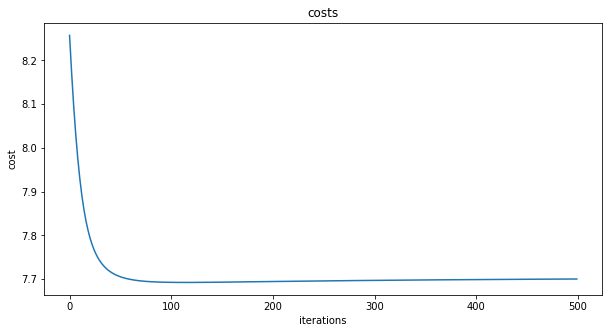

In [19]:
plot_cost(losses)

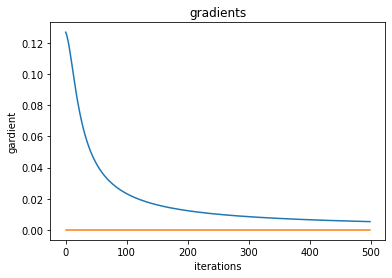

In [20]:
plot_gradients(gradients)

# TODO 4 : Régularisation
Mettre à jour le calcul du coût en ajoutant le terme de régularisation et comparer les résultats (avec et sans régularisation)

In [21]:
def NNCostFunction_avecRegularisation(X, YY, theta1, theta2,hidden_layer_sizen, learning_rate):
    #initialisation
    theta1_grad = np.zeros((theta1.shape[0],theta1.shape[1]))
    theta2_grad = np.zeros((theta2.shape[0],theta2.shape[1]))
    
    #faire la propagation en avant
    a1=X; 

    z2= np.zeros((X.shape[0],hidden_layer_size))
    a2= np.zeros((X.shape[0],hidden_layer_size)) 

    intercept=np.ones((X.shape[0],1))
    z2=np.column_stack((intercept,np.matmul(a1,np.transpose(theta1))))
    a2=Sigmoid(z2)
    a2[:,0]=1

    z3= np.zeros((YY.shape[0],YY.shape[1]))    
    a3= np.zeros((YY.shape[0],YY.shape[1]))  

    z3=np.matmul(a2,np.transpose(theta2))
    a3=Sigmoid(z3)
    
    #faire la propagation en arrière
    m = X.shape[0]
    for i in range(m):
        a1_ = a1[i,:][np.newaxis]
        z2_ = z2[i,:][np.newaxis]
        a2_ = a2[i,:][np.newaxis]
        a3_ = a3[i,:][np.newaxis]
        y_ = YY[i,:][np.newaxis]
        
        delta3 = a3_ - y_  
        
        z2_ = np.insert(z2_, 0, values=np.ones(1))  # (1, 26)
        
        var = (delta3 @ theta2)
        sigmoid_prime = a2_ * (1 - a2_)
        delta2 = np.multiply(var, sigmoid_prime) # (1, 26)

        theta1_grad = theta1_grad + (delta2[:,1:]).T * a1_
        theta2_grad = theta2_grad + delta3.T * a2_

        
    theta1_grad = theta1_grad / m
    theta2_grad = theta2_grad / m
    
    ### ajout de terme de régularisation
    theta1_grad[:,1:] = theta1_grad[:,1:] + (theta1[:,1:] * learning_rate) / m
    theta2_grad[:,1:] = theta2_grad[:,1:] + (theta2[:,1:] * learning_rate) / m
    
    # concaténétion des theta
    grad = np.concatenate((np.ravel(theta1_grad), np.ravel(theta2_grad)))

    # cost
    J = computeCost(X, YY, theta1, theta2, hidden_layer_size)
    return J, grad

In [22]:
def gradientDescent_avecRegularisation(X, y, theta, alpha, iterations):
    losses, gradients = [], []
    for _ in range(iterations):
        loss, grad = NNCostFunction_avecRegularisation(X, y, theta[0], theta[1], hidden_layer_size, alpha)
        
        theta[0] = theta[0] - alpha * grad[0]
        theta[1] = theta[1] - alpha * grad[1]
        
        losses.append(loss)
        gradients.append((grad[0].mean(), grad[1].mean()))
        
    return theta, np.asarray(losses), np.asarray(gradients)

In [23]:
#theta = [W1,W2]

w1_size = (hidden_layer_size, input_layer_size+1)
w2_size = (num_labels, hidden_layer_size+1)


np.random.seed(0)
w1 = np.random.normal(size = w1_size, loc = 0, scale = np.sqrt(2/410)) 
# scale est déterminé en appliquant la méthode "Xavier initialization" : sqrt(2/(input_layer_size + output_layer_size))

w2 = np.random.normal(size = w2_size, loc = 0, scale = np.sqrt(2/25)) 
# scale est déterminé en appliquant la méthode "Kaiming initialization" : sqrt(2/(hidden_layer_size))

theta_reg = [w1, w2]

In [24]:
theta_reg, losses_reg, gradients_reg = gradientDescent_avecRegularisation(X, YY, theta_reg, alpha, iterations)

### Traçage du coût et du gradient avec régularisation

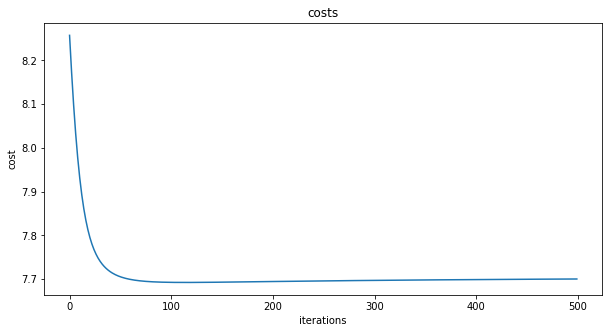

In [25]:
plot_cost(losses_reg)

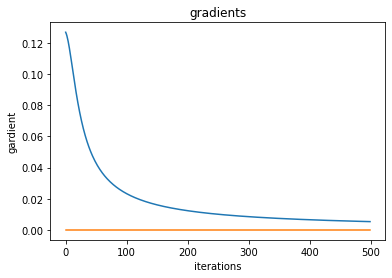

In [26]:
plot_gradients(gradients_reg)

# TODO 5 : Prédiction

Appliquer une propagation en avant en utilisant les paramètres données pour prédir les classes de l'ensemble d'apprentissage.



In [27]:
def predict (W1, W2, X):
    
    # appliquer une propagation en avant
    # !--- n'oubliez pas d'appliquer la sigmoid à chaque couche afin d'avoir les probabilités ---!
    
    # prédire la classe en choisissant la probabilité maximale parmi les 10 noeuds de sortie
    hiddenlayer1 = Sigmoid(X @ W1.T)
    
    intercept = np.ones((X.shape[0],1))
    
    hiddenlayer2 = np.column_stack((intercept, hiddenlayer1))
    hiddenlayer2 = Sigmoid(hiddenlayer2 @ W2.T)
    
    y_pred = np.argmax(hiddenlayer2, axis=1)[:, np.newaxis]
    
    return y_pred

- précision :

In [28]:
# calcul de precision = nombre de valeurs bien prédites (ici sur toute la base X)
y_pred=predict(theta[0], theta[1], X)
precision = np.mean(y==y_pred)*100
precision

17.740000000000002

- précision avec régularisation :

In [29]:
# calcul de precision = nombre de valeurs bien prédites (ici sur toute la base X)
y_pred=predict(theta_reg[0], theta_reg[1], X)
precision = np.mean(y==y_pred)*100
precision

17.740000000000002

# optionnel 1 : Vérification de l'implementation
Comparer vos algorithmes à ceux de scikitlearn

In [30]:
clf = MLPClassifier(solver='sgd', alpha=0.01, activation='logistic', max_iter=5000,
        hidden_layer_sizes=(25,))
clf.fit(X[:, 1:], YY)

MLPClassifier(activation='logistic', alpha=0.01, hidden_layer_sizes=(25,),
              max_iter=5000, solver='sgd')

In [31]:
y_pred = np.argmax(clf.predict(X[:, 1:]), axis=1)[:, np.newaxis]
precision = np.mean(y==y_pred)*100
precision

90.66

- On remarque que "scikitlearn" donne de meilleure résultats, en changeant les valeurs initiales de nos weights on pourra améliorer nos résultats, (par manque de temps, on n'a pas pu élaborer nos tests..)

# Optionnel 2 : Visualisation des poids
    
La visualisation de poids permet de voir quel partie du réseau est activé et pour quelle classe.
Il est possible de visulaiser les paramètres theta1 . 
Ceci peut se faire en utilisant un reshape de ces paramètres afin d'avoir 25 images de taille 20x20 (n'oubliez pas d'ignorer la premuère colonne, celle du biais)

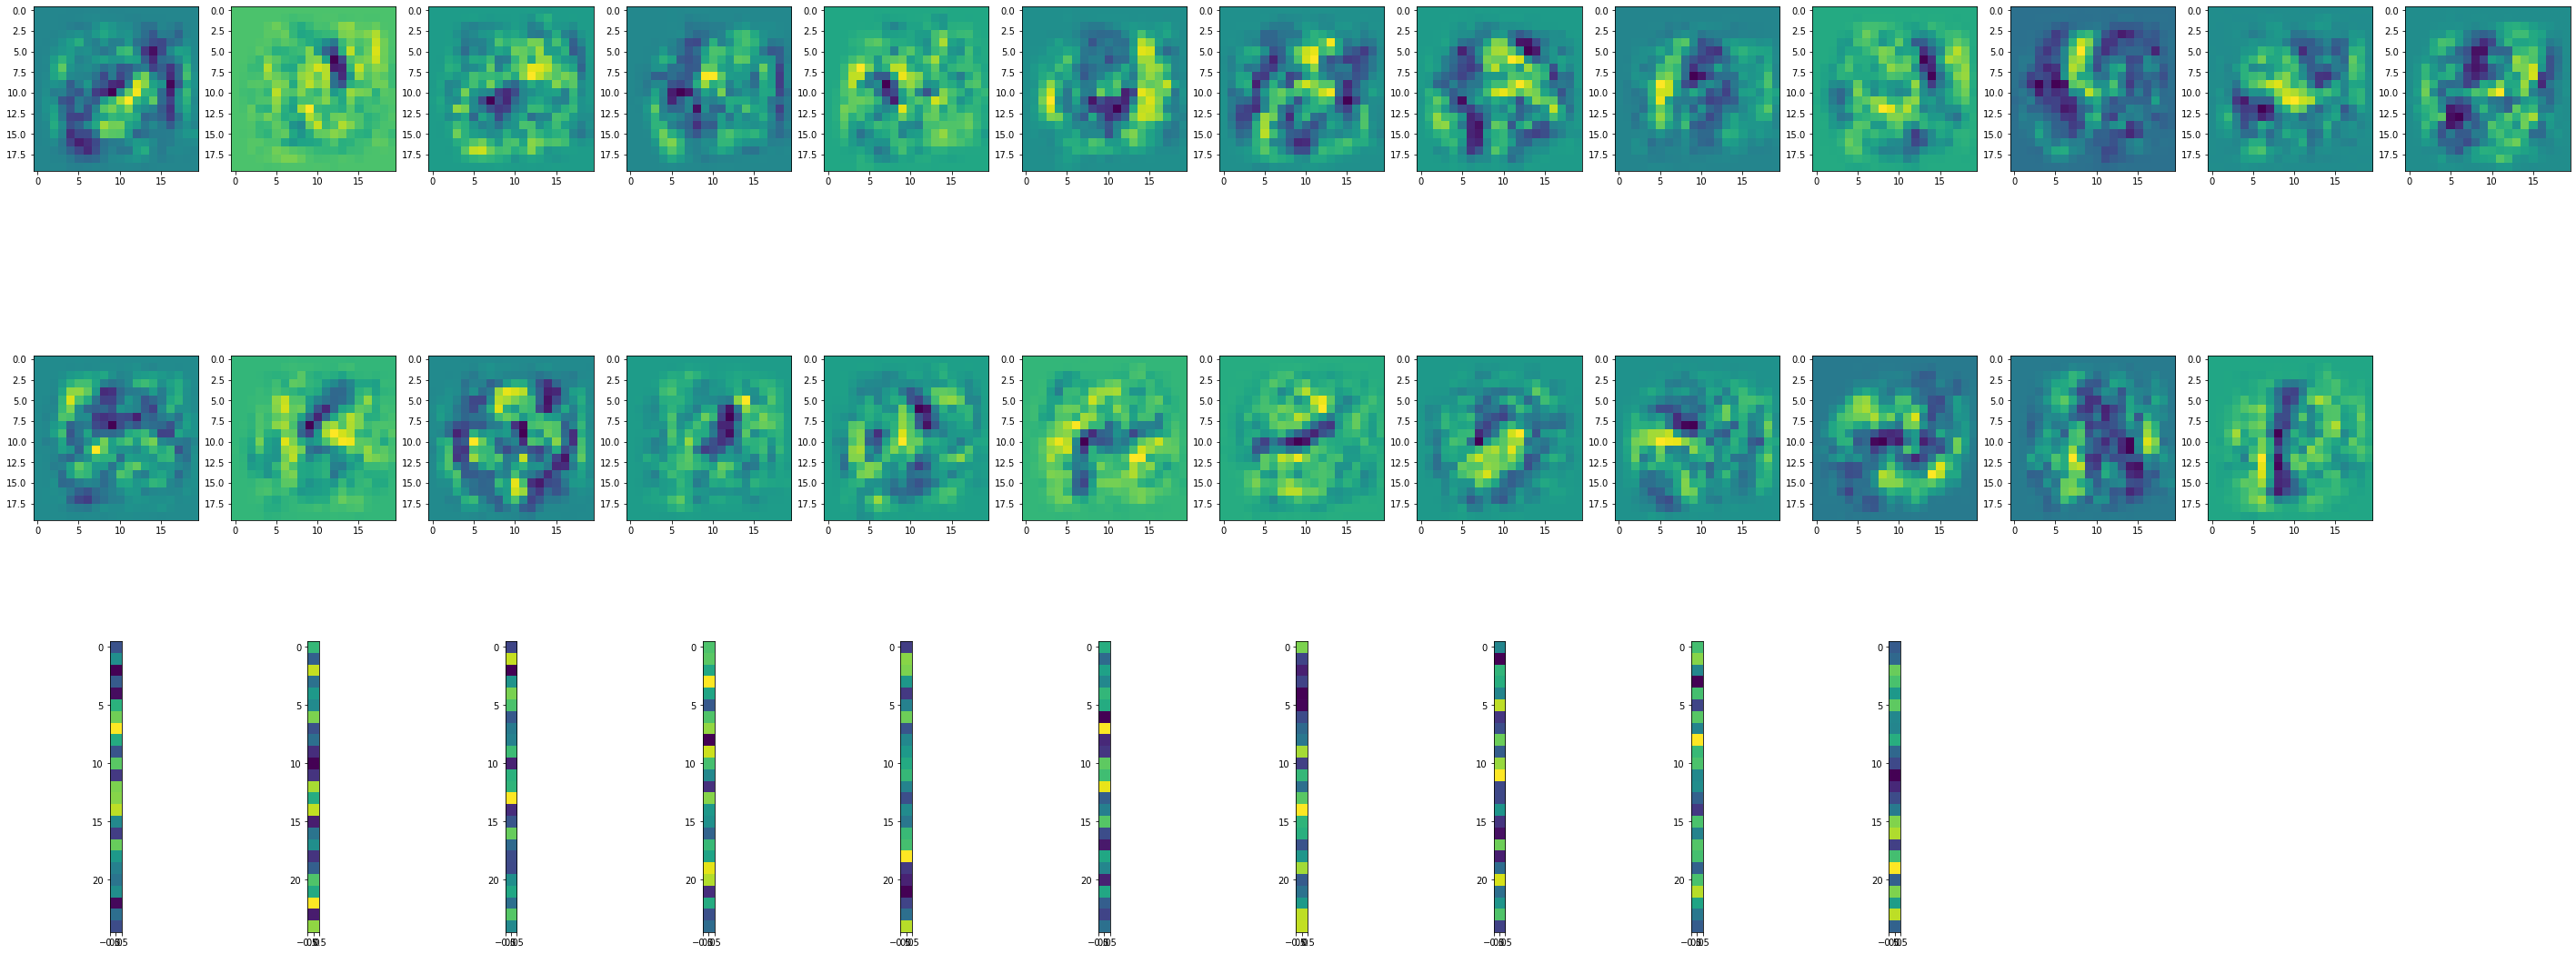

In [32]:
plt.figure(figsize=(50, 20))
for i in range(W1.shape[0]):
    plt.subplot(3, 13, i + 1)
    plt.imshow(np.reshape(W1[i][1:], (20, 20)))
for i in range(W2.shape[0]):
    plt.subplot(3, 13, W1.shape[0] + i + 2)
    plt.imshow(np.reshape(W2[i][1:], (-1, 1)))

# Optionnel 3 : Renforcement de l'apprentissage
Mettre ici toute idée qui pourrait renforcer votre apprentissage

# Consignes

Le travail est à remettre par groupe de 4 au maximum [1..4].

Le délai est le vendredi 29Avril 2022 à 22h


In [33]:
# bonne chance